In [105]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler as SS
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.preprocessing import OneHotEncoder as OE
from random import seed, random 
from sklearn.metrics import accuracy_score as acc
import math
import matplotlib.pyplot as plt

In [106]:
df = pd.read_csv("/content/letter-recognition.csv")
df

,Letter,X-box,Y-box,width,height,onpix,X-bar,Y-bar,x2bar,y2bar,xybar,x2ybar,xy2bar,X-ege,xegvy,Y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,D,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3,7
19996,C,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3,7
19997,T,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2,4
19998,S,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5,8


In [107]:
def data_preprocessing(DataFrame=None, Normalization_Type=None):
  Y = LE().fit_transform(DataFrame["Letter"]).reshape(-1,1)
  enc = OE(drop='first')
  Y = enc.fit_transform(Y).toarray()
  X = DataFrame.drop(columns=["Letter"])
  if Normalization_Type==None:
    return X,Y,enc
  else:
    X_Final = Normalization_Type.fit_transform(X)
    return X_Final,Y,enc

def train_test(x=None,y=None,test_split=0.25):
  split_list = tts(x,y,test_size=test_split)
  return list(split_list)

In [108]:
x,y,enc = data_preprocessing(df,SS())
split = train_test(x,y,0.1)

In [109]:
def activation_function(choice = None, w_x = None, alpha=0.1):
  if choice=='sigmoid':
    return 1/(1+np.exp(-w_x.astype(float)))
  elif choice=='relu':
    return (abs(w_x.astype(float))+w_x.astype(float))/2
  elif choice=='tanh':
    return np.tanh(w_x.astype(float))
  elif choice=="leaky_relu":
    return np.maximum(alpha*w_x, w_x)
  else:
    return w_x.tolist()

def activation_derivative(choice = None, output = None, alpha=0.1):
  output = np.array(output)
  if choice=='sigmoid':
    return output*(1-output)
  elif choice=='relu':
    y=output
    np.piecewise(y,[activation_function('relu',y)==0,activation_function('relu',y)==y],[0,1])
    return y
  elif choice=='tanh':
    return 1-np.square(activation_function('tanh',output))
  elif choice=="leaky_relu":
    y=output
    np.piecewise(y,[activation_function('leaky_relu',y)==alpha*y,activation_function('leaky_relu',y)==y],[alpha,1])
    return y
  else:
    return output

In [110]:
class Neural_Network():
  def __init__(self,x,y,h,choice,lr,alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8,choice_optim='SGD'):
    self.input=x
    self.weights1=np.random.randn(self.input.shape[1],h)
    self.weights2=np.random.randn(h,int(h/2))*np.sqrt(1/h)
    self.weights3=np.random.randn(int(h/2),y.shape[1])*np.sqrt(1/int(h/2))
    self.y=y
    self.output=np.zeros(y.shape)
    self.activations=choice
    self.lr=lr
    self.alpha = alpha
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.m = [0,0,0]
    self.v = [0,0,0]
    self.t = 0
    self.choice_optim = choice_optim

  def FeedForward(self):
    self.layer1=activation_function(self.activations[0],np.dot(self.input,self.weights1))
    self.layer2=activation_function(self.activations[1],np.dot(self.layer1,self.weights2))
    self.output=activation_function(self.activations[2],np.dot(self.layer2,self.weights3))
  
  def BackPropagation(self):
    m=self.input.shape[0]
    d_weights3=-(1/m)*np.dot(self.layer2.T,(self.y-self.output)*activation_derivative(self.activations[2],self.output))
    d_weights2=-(1/m)*np.dot(self.layer1.T,(np.dot((self.y-self.output)*activation_derivative(self.activations[2],self.output),self.weights3.T)*activation_derivative(self.activations[1],self.layer2)))
    d_weights1=-(1/m)*np.dot(self.input.T,(np.matmul(np.dot((self.y-self.output)*activation_derivative(self.activations[2],self.output),self.weights3.T)*activation_derivative(self.activations[1],self.layer2),self.weights2.T)*activation_derivative(self.activations[0],self.layer1)))
    grad = [d_weights3,d_weights2,d_weights1]
    if (self.choice_optim == 'Adam'):
      updated=[]
      self.t = self.t + 1
      for i in range(0,3):
        self.m[i] = self.beta1*self.m[i] + (1 - self.beta1)*grad[i]
        self.v[i] = self.beta2*self.v[i] + (1 - self.beta2)*np.square(grad[i])
        m_hat = self.m[i]/(1 - self.beta1**self.t)
        v_hat = self.v[i]/(1 - self.beta2**self.t)
        updated.append([m_hat,v_hat])
      self.weights3 = self.weights3 - self.alpha*(updated[0][0]/(np.sqrt(updated[0][1]) - self.epsilon))
      self.weights2 = self.weights2 - self.alpha*(updated[1][0]/(np.sqrt(updated[1][1]) - self.epsilon))
      self.weights1 = self.weights1 - self.alpha*(updated[2][0]/(np.sqrt(updated[2][1]) - self.epsilon))
    else:
      self.weights3=self.weights3-self.lr*d_weights3
      self.weights2=self.weights2-self.lr*d_weights2
      self.weights1=self.weights1-self.lr*d_weights1
  
  def predict(self,X):
    self.layert_1=activation_function(self.activations[0],np.dot(X,self.weights1))
    self.layert_2=activation_function(self.activations[1],np.dot(self.layert_1,self.weights2))
    return activation_function(self.activations[2],np.dot(self.layert_2,self.weights3))


In [111]:
n=split[1].shape[0]
m=split[0].shape[0]

#Default Adam

In [112]:
epochs=20
nn=Neural_Network(split[0],split[2],128,["tanh","tanh","sigmoid"],0.5,choice_optim="Adam")

loss_train_1=[]
loss_test_1=[]
acc_train_1=[]
acc_test_1=[]

for i in range(epochs):
   nn.FeedForward()
   nn.BackPropagation()
   cost_train=(1/m)*np.sum(np.multiply(nn.y,nn.output))
   cost_test=(1/m)*np.sum(np.multiply(split[3],nn.predict(split[1])))
   pred_train = nn.output.round()
   pred_test = nn.predict(split[1]).round()
   y_train=split[2]
   y_test=split[3]
   for i in range(pred_train.shape[0]):
     for j in range(pred_train.shape[1]):
       if pred_train[i][j]==y_train[i][j] and y_train[i][j]==1:
         pred_train[i][j]=1
       else:
         pred_train[i][j]=0
   for i in range(pred_test.shape[0]):
     for j in range(pred_test.shape[1]):
       if pred_test[i][j]==y_test[i][j] and y_test[i][j]==1:
         pred_test[i][j]=1
       else:
         pred_test[i][j]=0
   y_train=enc.inverse_transform(split[2])
   y_test=enc.inverse_transform(split[3])
   pred_train = enc.inverse_transform(pred_train)
   pred_test = enc.inverse_transform(pred_test)
   train_acc=(m-np.count_nonzero(y_train-pred_train))/m
   test_acc=(n-np.count_nonzero(y_test-pred_test))/n
   loss_train_1.append(cost_train)
   loss_test_1.append(cost_test)
   acc_train_1.append(train_acc*100)
   acc_test_1.append(test_acc*100)

# Adam with 25 epochs

In [113]:
epochs=25
nn=Neural_Network(split[0],split[2],128,["tanh","tanh","sigmoid"],0.5,choice_optim="Adam")

loss_train_12=[]
loss_test_12=[]
acc_train_12=[]
acc_test_12=[]

for i in range(epochs):
   nn.FeedForward()
   nn.BackPropagation()
   cost_train=(1/m)*np.sum(np.multiply(nn.y,nn.output))
   cost_test=(1/m)*np.sum(np.multiply(split[3],nn.predict(split[1])))
   pred_train = nn.output.round()
   pred_test = nn.predict(split[1]).round()
   y_train=split[2]
   y_test=split[3]
   for i in range(pred_train.shape[0]):
     for j in range(pred_train.shape[1]):
       if pred_train[i][j]==y_train[i][j] and y_train[i][j]==1:
         pred_train[i][j]=1
       else:
         pred_train[i][j]=0
   for i in range(pred_test.shape[0]):
     for j in range(pred_test.shape[1]):
       if pred_test[i][j]==y_test[i][j] and y_test[i][j]==1:
         pred_test[i][j]=1
       else:
         pred_test[i][j]=0
   y_train=enc.inverse_transform(split[2])
   y_test=enc.inverse_transform(split[3])
   pred_train = enc.inverse_transform(pred_train)
   pred_test = enc.inverse_transform(pred_test)
   train_acc=(m-np.count_nonzero(y_train-pred_train))/m
   test_acc=(n-np.count_nonzero(y_test-pred_test))/n
   loss_train_12.append(cost_train)
   loss_test_12.append(cost_test)
   acc_train_12.append(train_acc*100)
   acc_test_12.append(test_acc*100)

# Adam with 15 epochs

In [114]:
epochs=15
nn=Neural_Network(split[0],split[2],128,["tanh","tanh","sigmoid"],0.5,choice_optim="Adam")

loss_train_13=[]
loss_test_13=[]
acc_train_13=[]
acc_test_13=[]

for i in range(epochs):
   nn.FeedForward()
   nn.BackPropagation()
   cost_train=(1/m)*np.sum(np.multiply(nn.y,nn.output))
   cost_test=(1/m)*np.sum(np.multiply(split[3],nn.predict(split[1])))
   pred_train = nn.output.round()
   pred_test = nn.predict(split[1]).round()
   y_train=split[2]
   y_test=split[3]
   for i in range(pred_train.shape[0]):
     for j in range(pred_train.shape[1]):
       if pred_train[i][j]==y_train[i][j] and y_train[i][j]==1:
         pred_train[i][j]=1
       else:
         pred_train[i][j]=0
   for i in range(pred_test.shape[0]):
     for j in range(pred_test.shape[1]):
       if pred_test[i][j]==y_test[i][j] and y_test[i][j]==1:
         pred_test[i][j]=1
       else:
         pred_test[i][j]=0
   y_train=enc.inverse_transform(split[2])
   y_test=enc.inverse_transform(split[3])
   pred_train = enc.inverse_transform(pred_train)
   pred_test = enc.inverse_transform(pred_test)
   train_acc=(m-np.count_nonzero(y_train-pred_train))/m
   test_acc=(n-np.count_nonzero(y_test-pred_test))/n
   loss_train_13.append(cost_train)
   loss_test_13.append(cost_test)
   acc_train_13.append(train_acc*100)
   acc_test_13.append(test_acc*100)

# SGD with lr=0.5

In [115]:
epochs=20
nn=Neural_Network(split[0],split[2],128,["tanh","tanh","sigmoid"],0.5,choice_optim="SGD")

loss_train_2=[]
loss_test_2=[]
acc_train_2=[]
acc_test_2=[]

for i in range(epochs):
   nn.FeedForward()
   nn.BackPropagation()
   cost_train=(1/m)*np.sum(np.multiply(nn.y,nn.output))
   cost_test=(1/m)*np.sum(np.multiply(split[3],nn.predict(split[1])))
   pred_train = nn.output.round()
   pred_test = nn.predict(split[1]).round()
   y_train=split[2]
   y_test=split[3]
   for i in range(pred_train.shape[0]):
     for j in range(pred_train.shape[1]):
       if pred_train[i][j]==y_train[i][j] and y_train[i][j]==1:
         pred_train[i][j]=1
       else:
         pred_train[i][j]=0
   for i in range(pred_test.shape[0]):
     for j in range(pred_test.shape[1]):
       if pred_test[i][j]==y_test[i][j] and y_test[i][j]==1:
         pred_test[i][j]=1
       else:
         pred_test[i][j]=0
   y_train=enc.inverse_transform(split[2])
   y_test=enc.inverse_transform(split[3])
   pred_train = enc.inverse_transform(pred_train)
   pred_test = enc.inverse_transform(pred_test)
   train_acc=(m-np.count_nonzero(y_train-pred_train))/m
   test_acc=(n-np.count_nonzero(y_test-pred_test))/n
   loss_train_2.append(cost_train)
   loss_test_2.append(cost_test)
   acc_train_2.append(train_acc*100)
   acc_test_2.append(test_acc*100)

# SGD with lr=0.25

In [116]:
epochs=20
nn=Neural_Network(split[0],split[2],128,["tanh","tanh","sigmoid"],0.25,choice_optim="SGD")

loss_train_21=[]
loss_test_21=[]
acc_train_21=[]
acc_test_21=[]

for i in range(epochs):
   nn.FeedForward()
   nn.BackPropagation()
   cost_train=(1/m)*np.sum(np.multiply(nn.y,nn.output))
   cost_test=(1/m)*np.sum(np.multiply(split[3],nn.predict(split[1])))
   pred_train = nn.output.round()
   pred_test = nn.predict(split[1]).round()
   y_train=split[2]
   y_test=split[3]
   for i in range(pred_train.shape[0]):
     for j in range(pred_train.shape[1]):
       if pred_train[i][j]==y_train[i][j] and y_train[i][j]==1:
         pred_train[i][j]=1
       else:
         pred_train[i][j]=0
   for i in range(pred_test.shape[0]):
     for j in range(pred_test.shape[1]):
       if pred_test[i][j]==y_test[i][j] and y_test[i][j]==1:
         pred_test[i][j]=1
       else:
         pred_test[i][j]=0
   y_train=enc.inverse_transform(split[2])
   y_test=enc.inverse_transform(split[3])
   pred_train = enc.inverse_transform(pred_train)
   pred_test = enc.inverse_transform(pred_test)
   train_acc=(m-np.count_nonzero(y_train-pred_train))/m
   test_acc=(n-np.count_nonzero(y_test-pred_test))/n
   loss_train_21.append(cost_train)
   loss_test_21.append(cost_test)
   acc_train_21.append(train_acc*100)
   acc_test_21.append(test_acc*100)

# SGD with lr=0.75

In [117]:
epochs=20
nn=Neural_Network(split[0],split[2],128,["tanh","tanh","sigmoid"],0.75,choice_optim="SGD")

loss_train_22=[]
loss_test_22=[]
acc_train_22=[]
acc_test_22=[]

for i in range(epochs):
   nn.FeedForward()
   nn.BackPropagation()
   cost_train=(1/m)*np.sum(np.multiply(nn.y,nn.output))
   cost_test=(1/m)*np.sum(np.multiply(split[3],nn.predict(split[1])))
   pred_train = nn.output.round()
   pred_test = nn.predict(split[1]).round()
   y_train=split[2]
   y_test=split[3]
   for i in range(pred_train.shape[0]):
     for j in range(pred_train.shape[1]):
       if pred_train[i][j]==y_train[i][j] and y_train[i][j]==1:
         pred_train[i][j]=1
       else:
         pred_train[i][j]=0
   for i in range(pred_test.shape[0]):
     for j in range(pred_test.shape[1]):
       if pred_test[i][j]==y_test[i][j] and y_test[i][j]==1:
         pred_test[i][j]=1
       else:
         pred_test[i][j]=0
   y_train=enc.inverse_transform(split[2])
   y_test=enc.inverse_transform(split[3])
   pred_train = enc.inverse_transform(pred_train)
   pred_test = enc.inverse_transform(pred_test)
   train_acc=(m-np.count_nonzero(y_train-pred_train))/m
   test_acc=(n-np.count_nonzero(y_test-pred_test))/n
   loss_train_22.append(cost_train)
   loss_test_22.append(cost_test)
   acc_train_22.append(train_acc*100)
   acc_test_22.append(test_acc*100)

# Adam with ReLU

In [118]:
epochs=20
nn=Neural_Network(split[0],split[2],128,["relu","relu","sigmoid"],0.5,choice_optim="Adam")

loss_train_31=[]
loss_test_31=[]
acc_train_31=[]
acc_test_31=[]

for i in range(epochs):
   nn.FeedForward()
   nn.BackPropagation()
   cost_train=(1/m)*np.sum(np.multiply(nn.y,nn.output))
   cost_test=(1/m)*np.sum(np.multiply(split[3],nn.predict(split[1])))
   pred_train = nn.output.round()
   pred_test = nn.predict(split[1]).round()
   y_train=split[2]
   y_test=split[3]
   for i in range(pred_train.shape[0]):
     for j in range(pred_train.shape[1]):
       if pred_train[i][j]==y_train[i][j] and y_train[i][j]==1:
         pred_train[i][j]=1
       else:
         pred_train[i][j]=0
   for i in range(pred_test.shape[0]):
     for j in range(pred_test.shape[1]):
       if pred_test[i][j]==y_test[i][j] and y_test[i][j]==1:
         pred_test[i][j]=1
       else:
         pred_test[i][j]=0
   y_train=enc.inverse_transform(split[2])
   y_test=enc.inverse_transform(split[3])
   pred_train = enc.inverse_transform(pred_train)
   pred_test = enc.inverse_transform(pred_test)
   train_acc=(m-np.count_nonzero(y_train-pred_train))/m
   test_acc=(n-np.count_nonzero(y_test-pred_test))/n
   loss_train_31.append(cost_train)
   loss_test_31.append(cost_test)
   acc_train_31.append(train_acc*100)
   acc_test_31.append(test_acc*100)

# Adam with Leaky_ReLU

In [119]:
epochs=20
nn=Neural_Network(split[0],split[2],128,["leaky_relu","leaky_relu","sigmoid"],0.5,choice_optim="Adam")

loss_train_32=[]
loss_test_32=[]
acc_train_32=[]
acc_test_32=[]

for i in range(epochs):
   nn.FeedForward()
   nn.BackPropagation()
   cost_train=(1/m)*np.sum(np.multiply(nn.y,nn.output))
   cost_test=(1/m)*np.sum(np.multiply(split[3],nn.predict(split[1])))
   pred_train = nn.output.round()
   pred_test = nn.predict(split[1]).round()
   y_train=split[2]
   y_test=split[3]
   for i in range(pred_train.shape[0]):
     for j in range(pred_train.shape[1]):
       if pred_train[i][j]==y_train[i][j] and y_train[i][j]==1:
         pred_train[i][j]=1
       else:
         pred_train[i][j]=0
   for i in range(pred_test.shape[0]):
     for j in range(pred_test.shape[1]):
       if pred_test[i][j]==y_test[i][j] and y_test[i][j]==1:
         pred_test[i][j]=1
       else:
         pred_test[i][j]=0
   y_train=enc.inverse_transform(split[2])
   y_test=enc.inverse_transform(split[3])
   pred_train = enc.inverse_transform(pred_train)
   pred_test = enc.inverse_transform(pred_test)
   train_acc=(m-np.count_nonzero(y_train-pred_train))/m
   test_acc=(n-np.count_nonzero(y_test-pred_test))/n
   loss_train_32.append(cost_train)
   loss_test_32.append(cost_test)
   acc_train_32.append(train_acc*100)
   acc_test_32.append(test_acc*100)

# Adam with Sigmoid

In [121]:
epochs=20
nn=Neural_Network(split[0],split[2],128,["sigmoid","sigmoid","sigmoid"],0.5,choice_optim="Adam")

loss_train_33=[]
loss_test_33=[]
acc_train_33=[]
acc_test_33=[]

for i in range(epochs):
   nn.FeedForward()
   nn.BackPropagation()
   cost_train=(1/m)*np.sum(np.multiply(nn.y,nn.output))
   cost_test=(1/m)*np.sum(np.multiply(split[3],nn.predict(split[1])))
   pred_train = nn.output.round()
   pred_test = nn.predict(split[1]).round()
   y_train=split[2]
   y_test=split[3]
   for i in range(pred_train.shape[0]):
     for j in range(pred_train.shape[1]):
       if pred_train[i][j]==y_train[i][j] and y_train[i][j]==1:
         pred_train[i][j]=1
       else:
         pred_train[i][j]=0
   for i in range(pred_test.shape[0]):
     for j in range(pred_test.shape[1]):
       if pred_test[i][j]==y_test[i][j] and y_test[i][j]==1:
         pred_test[i][j]=1
       else:
         pred_test[i][j]=0
   y_train=enc.inverse_transform(split[2])
   y_test=enc.inverse_transform(split[3])
   pred_train = enc.inverse_transform(pred_train)
   pred_test = enc.inverse_transform(pred_test)
   train_acc=(m-np.count_nonzero(y_train-pred_train))/m
   test_acc=(n-np.count_nonzero(y_test-pred_test))/n
   loss_train_33.append(cost_train)
   loss_test_33.append(cost_test)
   acc_train_33.append(train_acc*100)
   acc_test_33.append(test_acc*100)

# Visualizations

##(a) Varying lr

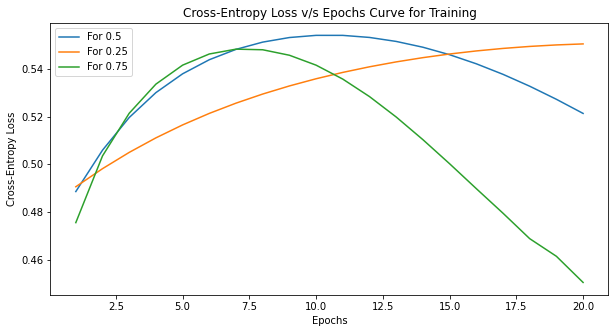

In [140]:
plt.figure(figsize=(10,5))
plt.title("Cross-Entropy Loss v/s Epochs Curve for Training")
plt.plot([i for i in range(1,epochs+1)],loss_train_2)
plt.plot([i for i in range(1,epochs+1)],loss_train_21)
plt.plot([i for i in range(1,epochs+1)],loss_train_22)
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.legend(["For 0.5","For 0.25","For 0.75"])
plt.show()

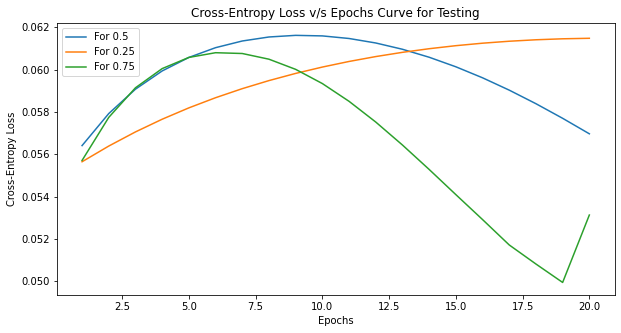

In [141]:
plt.figure(figsize=(10,5))
plt.title("Cross-Entropy Loss v/s Epochs Curve for Testing")
plt.plot([i for i in range(1,epochs+1)],loss_test_2)
plt.plot([i for i in range(1,epochs+1)],loss_test_21)
plt.plot([i for i in range(1,epochs+1)],loss_test_22)
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.legend(["For 0.5","For 0.25","For 0.75"])
plt.show()

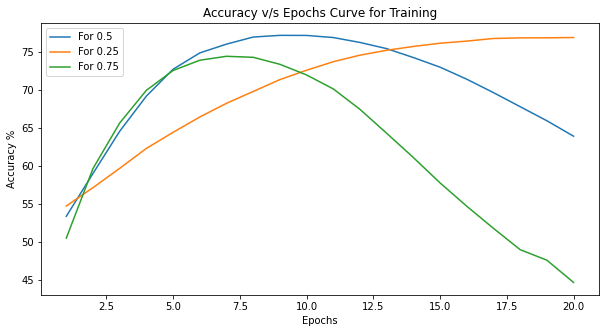

In [142]:
plt.figure(figsize=(10,5))
plt.title("Accuracy v/s Epochs Curve for Training")
plt.plot([i for i in range(1,epochs+1)],acc_train_2)
plt.plot([i for i in range(1,epochs+1)],acc_train_21)
plt.plot([i for i in range(1,epochs+1)],acc_train_22)
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.legend(["For 0.5","For 0.25","For 0.75"])
plt.show()

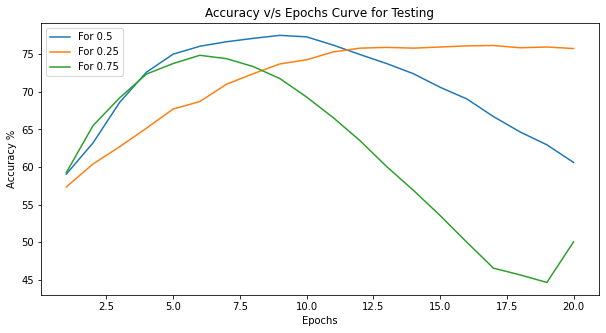

In [143]:
plt.figure(figsize=(10,5))
plt.title("Accuracy v/s Epochs Curve for Testing")
plt.plot([i for i in range(1,epochs+1)],acc_test_2)
plt.plot([i for i in range(1,epochs+1)],acc_test_21)
plt.plot([i for i in range(1,epochs+1)],acc_test_22)
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.legend(["For 0.5","For 0.25","For 0.75"])
plt.show()

##(b) Varying Number of Epochs

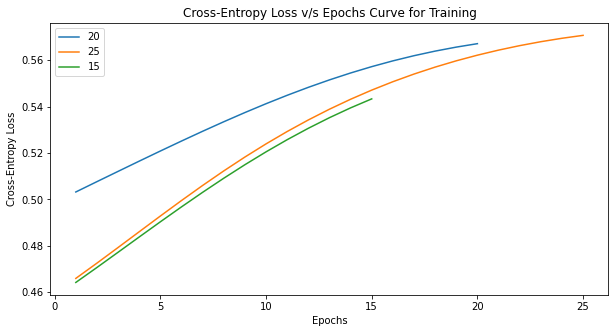

In [144]:
plt.figure(figsize=(10,5))
plt.title("Cross-Entropy Loss v/s Epochs Curve for Training")
plt.plot([i for i in range(1,21)],loss_train_1)
plt.plot([i for i in range(1,26)],loss_train_12)
plt.plot([i for i in range(1,16)],loss_train_13)
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.legend(["20","25","15"])
plt.show()

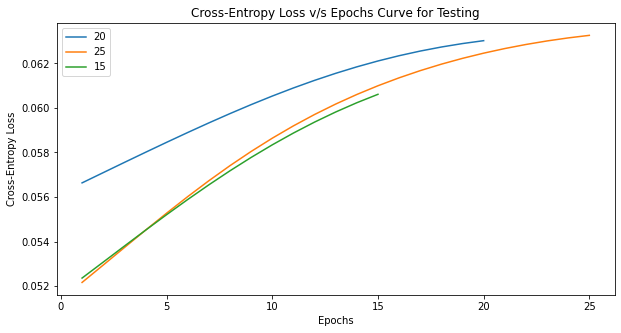

In [146]:
plt.figure(figsize=(10,5))
plt.title("Cross-Entropy Loss v/s Epochs Curve for Testing")
plt.plot([i for i in range(1,21)],loss_test_1)
plt.plot([i for i in range(1,26)],loss_test_12)
plt.plot([i for i in range(1,16)],loss_test_13)
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.legend(["20","25","15"])
plt.show()

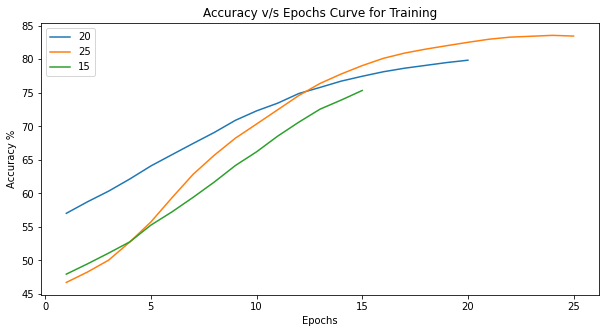

In [147]:
plt.figure(figsize=(10,5))
plt.title("Accuracy v/s Epochs Curve for Training")
plt.plot([i for i in range(1,21)],acc_train_1)
plt.plot([i for i in range(1,26)],acc_train_12)
plt.plot([i for i in range(1,16)],acc_train_13)
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.legend(["20","25","15"])
plt.show()

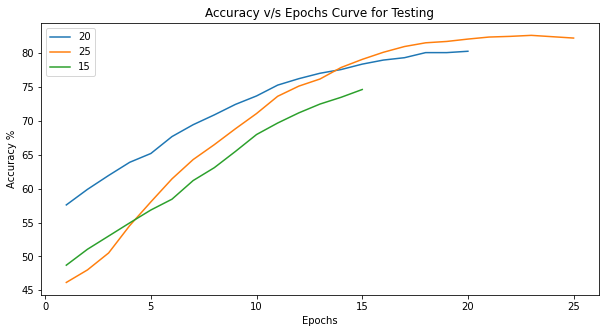

In [148]:
plt.figure(figsize=(10,5))
plt.title("Accuracy v/s Epochs Curve for Testing")
plt.plot([i for i in range(1,21)],acc_test_1)
plt.plot([i for i in range(1,26)],acc_test_12)
plt.plot([i for i in range(1,16)],acc_test_13)
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.legend(["20","25","15"])
plt.show()

##(d) Adam v/s SGD

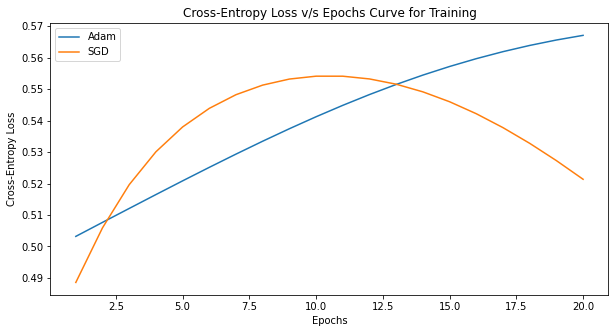

In [149]:
plt.figure(figsize=(10,5))
plt.title("Cross-Entropy Loss v/s Epochs Curve for Training")
plt.plot([i for i in range(1,epochs+1)],loss_train_1)
plt.plot([i for i in range(1,epochs+1)],loss_train_2)
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.legend(["Adam","SGD"])
plt.show()

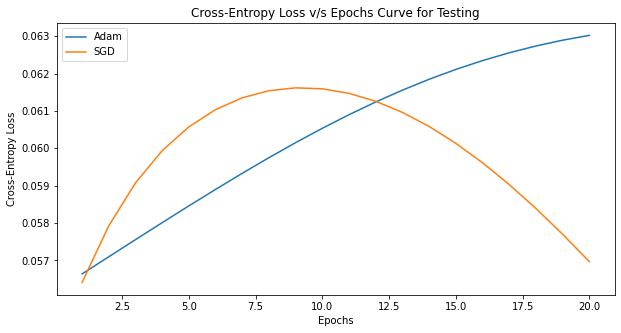

In [150]:
plt.figure(figsize=(10,5))
plt.title("Cross-Entropy Loss v/s Epochs Curve for Testing")
plt.plot([i for i in range(1,epochs+1)],loss_test_1)
plt.plot([i for i in range(1,epochs+1)],loss_test_2)
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.legend(["Adam","SGD"])
plt.show()

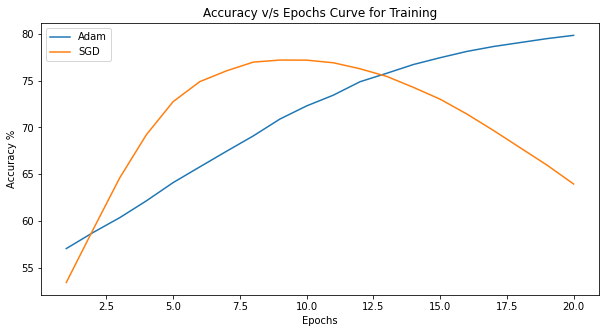

In [151]:
plt.figure(figsize=(10,5))
plt.title("Accuracy v/s Epochs Curve for Training")
plt.plot([i for i in range(1,epochs+1)],acc_train_1)
plt.plot([i for i in range(1,epochs+1)],acc_train_2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.legend(["Adam","SGD"])
plt.show()

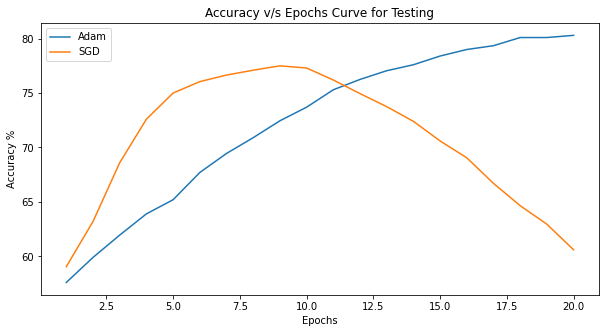

In [152]:
plt.figure(figsize=(10,5))
plt.title("Accuracy v/s Epochs Curve for Testing")
plt.plot([i for i in range(1,epochs+1)],acc_test_1)
plt.plot([i for i in range(1,epochs+1)],acc_test_2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.legend(["Adam","SGD"])
plt.show()

##(e) Varying Activation Functions

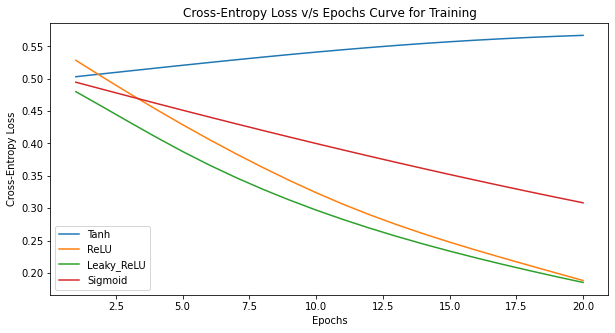

In [153]:
plt.figure(figsize=(10,5))
plt.title("Cross-Entropy Loss v/s Epochs Curve for Training")
plt.plot([i for i in range(1,epochs+1)],loss_train_1)
plt.plot([i for i in range(1,epochs+1)],loss_train_31)
plt.plot([i for i in range(1,epochs+1)],loss_train_32)
plt.plot([i for i in range(1,epochs+1)],loss_train_33)
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.legend(["Tanh","ReLU","Leaky_ReLU","Sigmoid"])
plt.show()

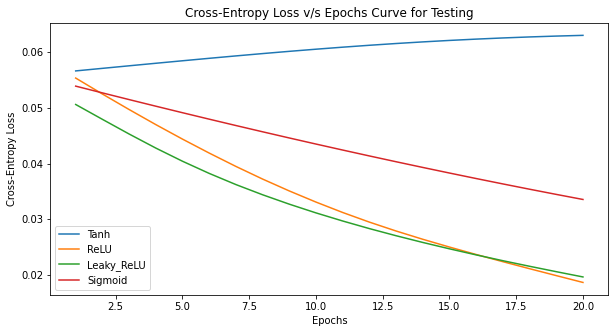

In [154]:
plt.figure(figsize=(10,5))
plt.title("Cross-Entropy Loss v/s Epochs Curve for Testing")
plt.plot([i for i in range(1,epochs+1)],loss_test_1)
plt.plot([i for i in range(1,epochs+1)],loss_test_31)
plt.plot([i for i in range(1,epochs+1)],loss_test_32)
plt.plot([i for i in range(1,epochs+1)],loss_test_33)
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.legend(["Tanh","ReLU","Leaky_ReLU","Sigmoid"])
plt.show()

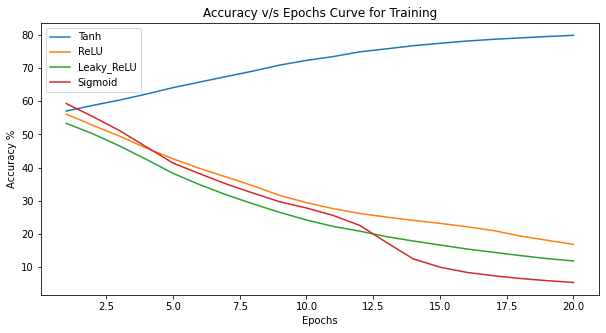

In [155]:
plt.figure(figsize=(10,5))
plt.title("Accuracy v/s Epochs Curve for Training")
plt.plot([i for i in range(1,epochs+1)],acc_train_1)
plt.plot([i for i in range(1,epochs+1)],acc_train_31)
plt.plot([i for i in range(1,epochs+1)],acc_train_32)
plt.plot([i for i in range(1,epochs+1)],acc_train_33)
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.legend(["Tanh","ReLU","Leaky_ReLU","Sigmoid"])
plt.show()

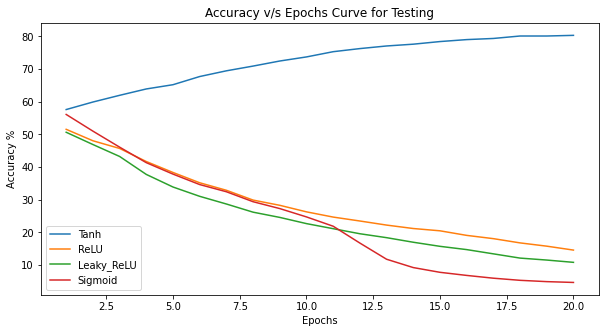

In [156]:
plt.figure(figsize=(10,5))
plt.title("Accuracy v/s Epochs Curve for Testing")
plt.plot([i for i in range(1,epochs+1)],acc_test_1)
plt.plot([i for i in range(1,epochs+1)],acc_test_31)
plt.plot([i for i in range(1,epochs+1)],acc_test_32)
plt.plot([i for i in range(1,epochs+1)],acc_test_33)
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.legend(["Tanh","ReLU","Leaky_ReLU","Sigmoid"])
plt.show()